In [1]:
import re
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(w, pos='n') for w in words]
    lem_words = [lemmatizer.lemmatize(w, pos='v') for w in lem_words]
    stopwords = {}.fromkeys([line.rstrip() for line in open('F:\\PycharmProjects\\NVDproject\\nvdcve\\stopwords.txt')])
    eng_stopwords = set(stopwords)
    words = [w for w in lem_words if w not in eng_stopwords]
    return words

In [2]:
import numpy as np
from gensim.models import fasttext  # 导入gensim包
import pandas as pd
import tensorflow as tf

years = ['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
infix = ''
infix = str(years[0])+"to"+str(years[len(years)-1])
# 标记
infix+='_no'
# cwe_min_count = 500
# cwe_min_count = 700
# cwe_min_count = 2000
# cwe_min_count = 2500
cwe_min_count = 3000
infix+='_'+str(cwe_min_count)
vec_len = 100
# vec_len = 200
# vec_len = 300
min_count = 1
window_len = 5
dense_unit = 128
fast_model_path  = '..//..//models//fasttext//'+infix+"_"+str(vec_len)+"_"+str(min_count)+"_"+str(window_len)+'.pkl'
label_path = '..\\..\\data\\clean\\nvdcve-1.1-'+infix+'_labels.csv'
n=30

cwe_count = 11
pl_size = n


def get_label_one_hot(list):
    values = np.array(list)
    n_values = np.max(values) + 1
    return np.eye(n_values)[values]

from tensorflow.keras.layers import Conv1D,Conv2D, BatchNormalization, Activation, MaxPool1D,MaxPool2D, Dropout, Flatten, Dense, GRU
from tensorflow.keras import Model


if __name__ == '__main__':
    dataset = pd.read_csv(label_path, header=None)
    fast_model = fasttext.FastText.load(fast_model_path)
    dataset.columns = ['cve_id', 'cwe_id', 'descript', 'label']
    dataset['contents'] = dataset['descript'].apply(clean_text)
    train_dataset = []
    for line in dataset['contents']:
        length = len(line)
        if length > n:
            line = line[:n]
            word2vec_matrix = (fast_model.wv[line])
            train_dataset.append(word2vec_matrix)
        else:
            word2vec_matrix = (fast_model.wv[line])
            pad_length = n - length
            pad_matrix = np.zeros([pad_length, vec_len]) + 1e-10
            word2vec_matrix = np.concatenate([word2vec_matrix, pad_matrix], axis=0)
            train_dataset.append(word2vec_matrix)
    # train_dataset = np.expand_dims(train_dataset, 3)
    label_dataset = get_label_one_hot(dataset['label'])

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_dataset, label_dataset, test_size=0.2, random_state=217)

In [4]:
print(len(x_train),len(x_test))

68069 17018


In [5]:
import keras_metrics as km
from tensorflow.keras.metrics import Precision,Recall 
Metrics = ['accuracy',Precision(),Recall(),km.f1_score()]

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
    # 顺序模型
model = Sequential()
model.add(Conv1D(256, 3, padding='same', strides=1, activation='relu'))
model.add(MaxPool1D(pool_size=2))
# model.add(MaxPool1D(pool_size=n))
model.add(GRU(256, return_sequences=True))
model.add(GRU(256, dropout=0.5, recurrent_dropout=0.1))
model.add(Dense(cwe_count, activation="softmax"))
x_train, x_test, y_train, y_test = train_test_split(train_dataset, label_dataset, test_size=0.2, random_state=217)
batch_size = 32
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    
#Metrics = ['accuracy']
model.compile(optimizer=tf.optimizers.Adam(1e-3),
                  loss=tf.losses.categorical_crossentropy, metrics=Metrics)


In [7]:
history = model.fit(train_data, epochs=10)
score = model.evaluate(np.array(x_test), y_test)
print('last score:', score)
print(model.summary())

Epoch 1/10


C:\Users\Lzh\miniconda3\envs\TF2.4\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


2128/2128 [==============================] - 106s 47ms/step - loss: 0.7734 - accuracy: 0.7253 - precision: 0.8478 - recall: 0.6396 - f1_score: 0.5008
Epoch 2/10
2128/2128 [==============================] - 100s 47ms/step - loss: 0.3734 - accuracy: 0.8774 - precision: 0.9036 - recall: 0.8533 - f1_score: 0.7994
Epoch 3/10
2128/2128 [==============================] - 100s 47ms/step - loss: 0.3227 - accuracy: 0.8941 - precision: 0.9156 - recall: 0.8755 - f1_score: 0.8326
Epoch 4/10
2128/2128 [==============================] - 100s 47ms/step - loss: 0.2823 - accuracy: 0.9084 - precision: 0.9242 - recall: 0.8930 - f1_score: 0.8667
Epoch 5/10
2128/2128 [==============================] - 101s 48ms/step - loss: 0.2427 - accuracy: 0.9213 - precision: 0.9347 - recall: 0.9093 - f1_score: 0.8812
Epoch 6/10
2128/2128 [==============================] - 101s 47ms/step - loss: 0.2076 - accuracy: 0.9327 - precision: 0.9420 - recall: 0.9234 - f1_score: 0.9016
Epoch 7/10
2128/2128 [=======================

In [8]:
import matplotlib.pyplot as plt
def print_history(history):
    # 绘制训练 & 验证的准确率值
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model accuracy&loss')
    plt.xlabel('Epoch')
    plt.legend(['Train_acc', 'Val_acc', 'Train_loss', 'Val_loss'])
    plt.show()

In [6]:
print(history.history)


{'loss': [0.5362193584442139, 0.36194998025894165, 0.31437331438064575, 0.274202823638916, 0.23500196635723114, 0.1981135606765747, 0.16954921185970306, 0.144243061542511, 0.1218026727437973, 0.10748542100191116], 'accuracy': [0.8158045411109924, 0.8797690868377686, 0.8966196179389954, 0.9101353287696838, 0.9242092370986938, 0.9358298182487488, 0.9454083442687988, 0.9539437890052795, 0.9608485698699951, 0.9649620056152344], 'precision': [0.8773637413978577, 0.9050509333610535, 0.915477454662323, 0.9256190657615662, 0.936574399471283, 0.9451414942741394, 0.9528075456619263, 0.9597384333610535, 0.9651815891265869, 0.9691581130027771], 'recall': [0.7681910991668701, 0.8586875200271606, 0.8802538514137268, 0.8961789011955261, 0.9132938385009766, 0.9273825287818909, 0.9390618205070496, 0.9486843943595886, 0.9570142030715942, 0.9615978002548218], 'f1_score': [0.6497175693511963, 0.8165560960769653, 0.8439810872077942, 0.8634837865829468, 0.8843351006507874, 0.8979121446609497, 0.914578855037

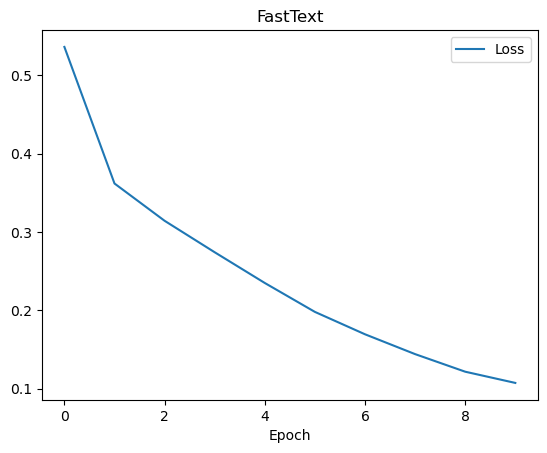

In [16]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['precision'])
# plt.plot(history.history['recall'])
# plt.plot(history.history['f1_score'])
plt.plot(history.history['loss'])
plt.title('FastText')
plt.xlabel('Epoch')
# plt.legend(['Accuracy','Precision','Recall','F1-Score'])
plt.legend(['Loss'])
plt.savefig('E:\软件开发实践\毕设项目\论文\ss_pku_thesis\pic\FastText_loss.png')

In [14]:
plt.savefig('E:\软件开发实践\毕设项目\论文\ss_pku_thesis\pic\FastText.png')

<Figure size 640x480 with 0 Axes>